# notebook reproducing anxiety paper

In [3]:
!pip install heartpy
!pip install wfdb

     |████████████████████████████████| 1.0 MB 16.2 MB/s 
     |████████████████████████████████| 11.5 MB 37.3 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.4.2
    Not uninstalling matplotlib at /shared-libs/python3.7/py/lib/python3.7/site-packages, outside environment /root/venv
    Can't uninstall 'matplotlib'. No files were found to uninstall.
     |████████████████████████████████| 137 kB 21.5 MB/s 


In [163]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import wfdb
from scipy import signal 
from wfdb import processing
from heartpy.datautils import rolling_mean, _sliding_window
from heartpy.peakdetection import detect_peaks, make_windows, check_peaks, fit_peaks
from heartpy import process_segmentwise
from heartpy.analysis import calc_rr
import heartpy as hp


In [5]:
# Constants
# SAMPLE_RATE = 250 # in Hz 
WINDOW_SIZE = 120 # in seconds

In [176]:
#Utilities 

# Takes a looong (filtered) signal and noramlizes it 
def normalize_signal(signal):
    return (signal - signal.mean()) / signal.std()  

def bandpass_filter(data, sample_rate, min_size): 
    filtered = hp.filter_signal(data, cutoff=[5, 12], sample_rate=sample_rate, order=3, filtertype='bandpass')
    return filtered 

# filter and window (& normalize) data 
def window(data, sample_rate, windowsize, overlap, min_size, filter=True): 
    """
    :param data:
    :param overlap float: number in [0.0, 1.0) the proportion of overlap between windows

    """
    if filter: 
        data = bandpass_filter(data, sample_rate, min_size)
    window_inds = make_windows(data, sample_rate, windowsize, overlap, min_size)
    n_filtered = normalize_signal(data) # normalized and filtered
    windowed_data = np.array([data[i[0]: i[1]] for i in window_inds])
    n_windowed_data = np.array([n_filtered[i[0] : i[1]] for i in window_inds])
    return windowed_data , n_windowed_data 

def RR_intervals(data, sample_rate, windowsize = .75, ma_perc = 20, bpmmin=40, bpmmax=180): 
    
    working_data = {}
    bl_val = np.percentile(data, 0.1)
    if bl_val < 0:
        print('scaling data by absolute value')
        data = data + abs(bl_val)

    working_data['hr'] = data
    working_data['sample_rate'] = sample_rate

    rol_mean = rolling_mean(data, windowsize, sample_rate)

    peaks = fit_peaks(data, rol_mean, sample_rate, bpmmin=bpmmin,
                             bpmmax=bpmmax, working_data=working_data) 
    
    working_data = calc_rr(working_data['peaklist'], sample_rate, working_data=working_data)

    working_data = check_peaks(working_data['RR_list'], working_data['peaklist'], working_data['ybeat'],
                               False, working_data=working_data)

    return working_data

def clean_nans(df): 
    # df = df.replace([np.inf, -np.inf], np.nan)
    # df[~np.isfinite(df)] = np.nan
    df.dropna(inplace=True)
    return df

def load_visualise(ecg, peaks, zoom=[]):
    if zoom: #explore signal
        plt.figure(figsize=(12,3))
        plt.scatter(peaks, [ecg[int(x)] for x in peaks], color='red')
        plt.title("Filtering:{}, Zoom:{}".format(filter, zoom))
        plt.plot(ecg)
        plt.xlim(zoom[0], zoom[1])
        plt.show()
    else: 
    #and zoom in
        plt.figure(figsize=(12,3))
        plt.scatter(peaks, [ecg[int(x)] for x in peaks], color='red')
        plt.plot(ecg)
        plt.title("Filtering:{}, Zoom:{}".format(filter, zoom))
        plt.show()
    
    return ecg


In [229]:
# Features 

"""
Notch and butteroworth bandpass 
Need: NFD, NSD, HRV, (+)avNN, (+) sdNN, (+)rmSSD, NN50, (+)pNN50, (+)pNN20

Already have from the processing tools
3?,8,9,10,11,12 

"""

# Should we gonna forget about HR Nmean ? 

# Mean of abs of normalized first differences
def get_nfd(n_signal): # (4)
    # takes normalized signal window --> returns feature 
    diffs = abs(n_signal[:-1] - n_signal[1:])
    return diffs.mean() 

# mean of abs values of normed second differences
def get_nsd(n_signal): # (5)
    # normalized signal window --> feature
    second_diffs = abs(n_signal[:-2] - n_signal[2:])
    return second_diffs.mean() 

# HRV, get the nn_intervals / window from "process segmentwise"
def get_hrv(nn_intervals): # (6)
    # takes list of nn_intervals (i.e. rr_intervals) [the intervals not the peaks!]
    # Returns the heart rate variability (HRV)
    return (nn_intervals[:-1] - nn_intervals[1:]).mean() 

# Average normal to normal intervals
def get_avNN(nn_intervals): # (7)
    return nn_intervals.mean() 

def get_sdNN(nn_intervals, avNN): # (8)
    return np.sqrt(((nn_intervals - avNN)**2).mean()) 
    
def get_rMSSD(nn_intervals): # (9)
    return np.sqrt(((nn_intervals[1:] - nn_intervals[:-1])**2).mean())

# Don't use feature (10) because it's stupid
"""
This function at the bottom gets all the features we need about a window
"""

FEAT_NAMES = ["nfd", "nsd", "hrv", "avNN", "sdNN", "rMSSD", "pNN20", "pNN50"]

def get_all_features(win, n_win, sr):
    """
    :param window np.ndarray: 1d array, 2 second filtered window of data
    :param n_window np.ndarray: 1d array, 2 second normalized window
    """
    # process data using the utils and extract relevant features automatically
    wd, m = hp.process(win, sample_rate = sr)
    rr_intervals = wd['RR_list'] / 4
    # there are ready made features stored in m 
    pNN20, pNN50 = m['pnn20'] , m['pnn50']

    # extract some features
    # Note : rr_intervals === nn_intervals
    nfd, nsd, hrv, avNN = get_nfd(n_win), get_nsd(n_win), get_hrv(rr_intervals),get_avNN(rr_intervals) # 4, 5, 6, 7
    sdNN = get_sdNN(rr_intervals, avNN) # 8
    rMSSD = get_rMSSD(rr_intervals) # 9 

    features = [nfd, nsd, hrv, avNN, sdNN, rMSSD, pNN20, pNN50]
    return np.array(features)

def get_features_matrix(data, sr):
    windows, n_windows = window(data, sr, windowsize=10, overlap=0, min_size=0, filter=True) 
    features_mat = []
    for win,n_win in zip(windows,n_windows):
        features_mat.append(get_all_features(win, n_win, sr)) 
    return np.array(features_mat)

In [241]:
# data2 = hp.get_data("e0103.csv")



signals, fields = wfdb.rdsamp('drive03', pn_dir='drivedb')
patient_data = pd.DataFrame(signals, columns=fields['sig_name'], dtype='float')
patient_data.dropna(inplace=True)
data = np.asarray(patient_data['ECG'])



# fm = get_features_matrix(data2, sr = fields['fs'] ) 
# print(fm.shape)


(5807, 8)


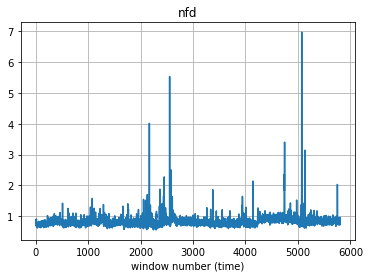

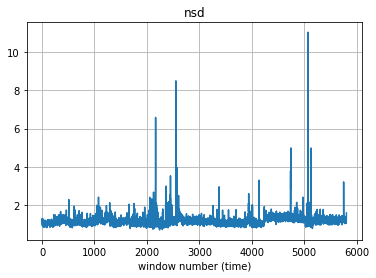

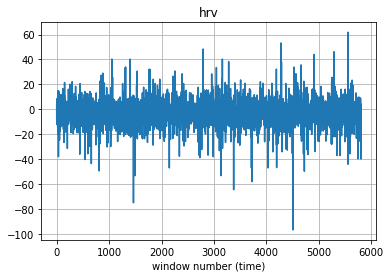

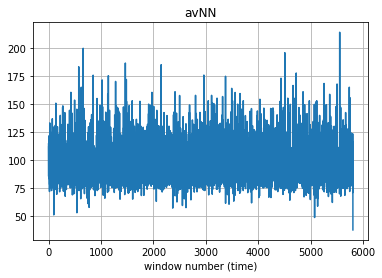

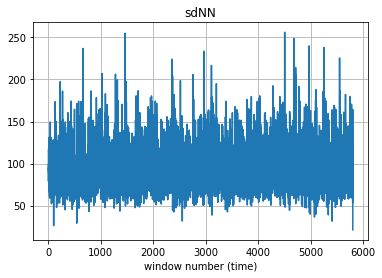

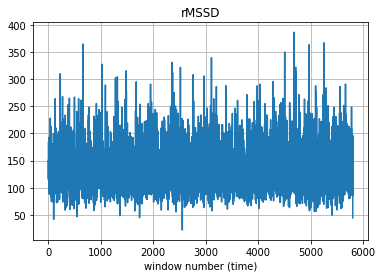

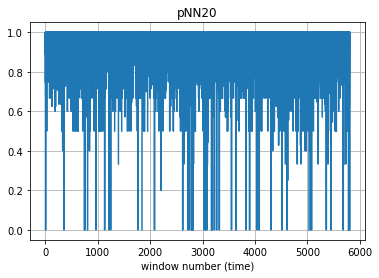

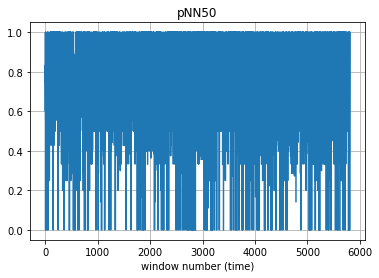

In [234]:
# fm = get_features_matrix(data) 
print(fm.shape) 

# lets plot a few features as signals
for feat,name in zip(fm.T,FEAT_NAMES):
    plt.figure()
    plt.plot(feat)
    plt.grid()
    plt.title(name)
    plt.xlabel("window number (time)")
    plt.show()


dict_keys(['hr', 'sample_rate', 'peaklist', 'ybeat', 'rolling_mean', 'RR_list', 'RR_indices', 'RR_diff', 'RR_sqdiff', 'rrsd', 'best', 'removed_beats', 'removed_beats_y', 'binary_peaklist', 'RR_masklist', 'RR_list_cor', 'nn20', 'nn50', 'poincare', 'breathing_signal', 'breathing_psd', 'breathing_frq'])
250
[0.876 0.932 1.004 0.996 1.016 0.972 1.036 1.032 0.992 0.956 0.96  0.964
 0.956 0.984 1.004 0.944 0.952 0.976 0.96  0.988 1.028 1.04  1.044 1.008
 1.028 1.052 1.024 1.044 1.072 1.048 1.032 1.016 1.06  1.088 1.068 1.016
 1.056 1.084 1.048 1.004 1.024 1.004 1.012 1.016 1.024 1.044 1.06  1.004
 1.064 1.08  1.064 1.056 1.084 1.048 1.032 0.984 1.036 1.06  1.072 1.068
 1.004 0.968 1.028 1.04  1.072 1.032 1.036 1.024 1.04  1.012 1.    1.016
 1.012 1.008 0.98  0.984 0.984 1.02  1.008 0.968 1.004 1.016 1.    1.
 1.012 1.028 1.008 1.036 1.036 1.016 0.976 0.948 0.984 1.04  1.024 1.04
 0.992 1.    1.02  1.004 0.94  0.876 0.872 0.904 0.924 0.884 0.912 0.924
 0.948 0.976 0.968 0.968 0.976 0.972 0.99

59.697000100331095

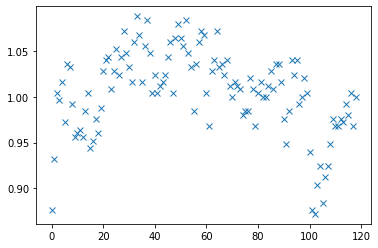

In [73]:
print(wd.keys())
print(wd['sample_rate'])
# print(wd['peaklist'])
peaks = np.array(wd['peaklist'])
rr_intervals = (peaks[1:] - peaks[:-1]) / SAMPLE_RATE
print(rr_intervals)
plt.plot(rr_intervals,"x")
# rr = wd['RR_diff']
# rr.data / 250

print(m.keys())
m['bpm']

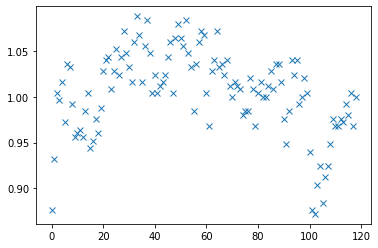

In [59]:
# windows, n_windows = filter_and_window(data, 250, 120, 0, 20)
# rr_intervals = RR_intervals(n_windows[0], sample_rate=250, windowsize=120)
# rr_intervals.shape, rr_intervals 

# plt.plot(rr_intervals / SAMPLE_RATE,"x")
plt.plot(wd['RR_list'] / (4*SAMPLE_RATE), 'x')
plt.show()

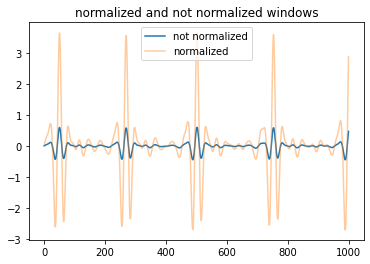

In [ ]:
plt.plot(windows[0][:1000], label="not normalized")
plt.plot(n_windows[0][:1000],alpha=0.4, label="normalized") 
plt.legend()
plt.title("normalized and not normalized windows")
plt.show()

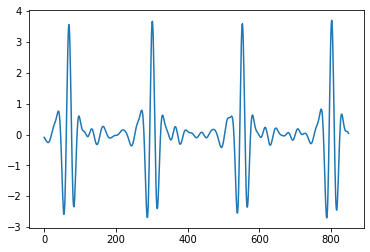

In [ ]:

plt.plot(filtered[0][200:1050])
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7dfaf0cf-71f2-4974-b0bd-c4ce0ae4b6aa' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>